Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/16 14:28:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/16 14:28:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+---------+--------+--------------------+--------------------+-----------+------------------+-----------+-----------+-----------+-----------+
|clonesize|honeybee|AverageOfUpperTRange|AverageOfLowerTRange|RainingDays|AverageRainingDays|   fruitset|  fruitmass|      seeds|      yield|
+---------+--------+--------------------+--------------------+-----------+------------------+-----------+-----------+-----------+-----------+
|     37.5|    0.75|                71.9|                50.8|       16.0|              0.26|0.410652063|0.408159008|31.67889844|3813.165795|
|     37.5|    0.75|                71.9|                50.8|        1.0|               0.1|0.444254359|0.425457642|33.44938499|4947.605663|
|     37.5|    0.75|                79.0|                55.9|       16.0|              0.26|0.383786508|0.399172403|30.54630597|3866.798965|
|     37.5|    0.75|                79.0|                55.9|        1.0|               0.1|0.407564155| 0.40878935|31.56258602| 4303.94303|
|     

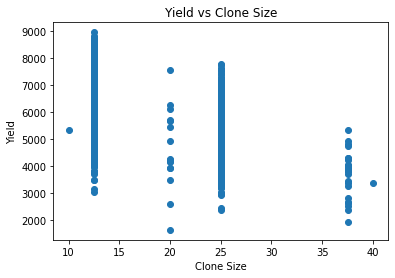

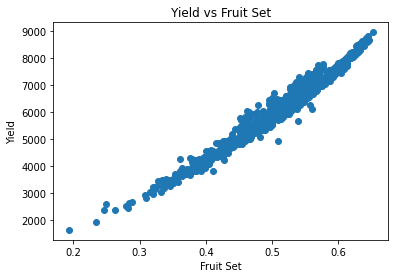

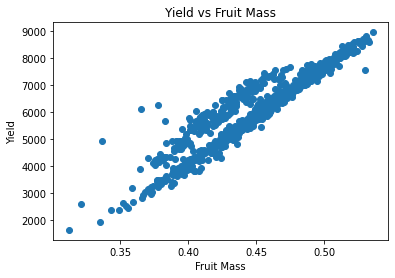

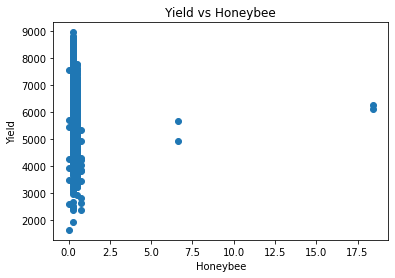

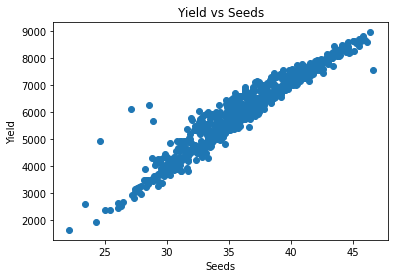

Extreme counts per column:
clonesize: 0
honeybee: 0
AverageOfUpperTRange: 0
AverageOfLowerTRange: 0
RainingDays: 0
AverageRainingDays: 0
fruitset: 9
fruitmass: 0
seeds: 0
yield: 2
Outlier counts per column:
clonesize: 0
honeybee: 0
AverageOfUpperTRange: 0
AverageOfLowerTRange: 0
RainingDays: 0
AverageRainingDays: 0
fruitset: 0
fruitmass: 0
seeds: 0
yield: 0
+-----------+-------------------------+-------------------------+--------------------+-------------------+--------------------+
|      yield|Norm_AverageOfUpperTRange|Norm_AverageOfLowerTRange|    Norm_RainingDays|      Norm_honeybee|                CEII|
+-----------+-------------------------+-------------------------+--------------------+-------------------+--------------------+
|3813.165795|      0.41382954327464594|       0.4059323993943852|-0.19046924561483558| 2.9248140992843887|  0.8885266990846461|
|4947.605663|      0.41382954327464594|       0.4059323993943852| -1.4276616403052476| 2.9248140992843887|   0.579228600412043|


+-----------+---------+--------+--------------------+--------------------+-----------+------------------+-----------+-----------+-----------+--------------------+
|      yield|clonesize|honeybee|AverageOfUpperTRange|AverageOfLowerTRange|RainingDays|AverageRainingDays|   fruitset|  fruitmass|      seeds|                CEII|
+-----------+---------+--------+--------------------+--------------------+-----------+------------------+-----------+-----------+-----------+--------------------+
|3813.165795|     37.5|    0.75|                71.9|                50.8|       16.0|              0.26|0.410652063|0.408159008|31.67889844|  0.8885266990846461|
|4947.605663|     37.5|    0.75|                71.9|                50.8|        1.0|               0.1|0.444254359|0.425457642|33.44938499|   0.579228600412043|
|3866.798965|     37.5|    0.75|                79.0|                55.9|       16.0|              0.26|0.383786508|0.399172403|30.54630597|  1.3559115538886815|
| 4303.94303|     37.5

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean as _mean, stddev as _stddev, rand
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

import findspark

import pyspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, mean as _mean
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
spark = SparkSession.builder.appName('linear_regression_adv').getOrCreate()

file = "WildBlueberryPollinationSimulationData (1).csv" 
df = spark.read.csv(file, header=True, inferSchema=True)



# 选择所需列
selected_columns = [
    'clonesize', 'honeybee', 'AverageOfUpperTRange',
    'AverageOfLowerTRange', 'RainingDays', 'AverageRainingDays', 
    'fruitset', 'fruitmass', 'seeds', 'yield'
]
selected_df = df.select(selected_columns)
selected_df.show()
# 计算缺失值百分比
missing_percentage = selected_df.select([(F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)) / selected_df.count() * 100).alias(c) for c in selected_df.columns])
missing_percentage.show()


min_value = selected_df.agg(F.min(col("AverageOfLowerTRange"))).collect()[0][0]
max_value = selected_df.agg(F.max(col("AverageOfLowerTRange"))).collect()[0][0]


# Fill the missing value
selected_df = selected_df.withColumn("AverageOfLowerTRange", when(col("AverageOfLowerTRange").isNull(), rand() * (max_value - min_value) + min_value).otherwise(col("AverageOfLowerTRange")))
missing_percentage = selected_df.select([(F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)) / selected_df.count() * 100).alias(c) for c in selected_df.columns])
missing_percentage.show()

# plot the scatter of the extreme and outlier vailables
def plot_scatter(x_col, y_col, x_label, y_label, title):
    x_data = selected_df.select(x_col).rdd.flatMap(lambda x: x).collect()
    y_data = selected_df.select(y_col).rdd.flatMap(lambda x: x).collect()
    plt.figure(figsize=(6, 4))
    plt.scatter(x_data, y_data)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

plot_scatter('clonesize', 'yield', 'Clone Size', 'Yield', 'Yield vs Clone Size')
plot_scatter('fruitset', 'yield', 'Fruit Set', 'Yield', 'Yield vs Fruit Set')
plot_scatter('fruitmass', 'yield', 'Fruit Mass', 'Yield', 'Yield vs Fruit Mass')
plot_scatter('honeybee', 'yield', 'Honeybee', 'Yield', 'Yield vs Honeybee')
plot_scatter('seeds', 'yield', 'Seeds', 'Yield', 'Yield vs Seeds')

# Replace the outlier
def replace_outliers_with_median(df, column):
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median_value = df.approxQuantile(column, [0.5], 0.01)[0]
    df = df.withColumn(column, when((col(column) < lower_bound) | (col(column) > upper_bound), median_value).otherwise(col(column)))
    return df


def replace_extremes_with_median(df, column):
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    median_value = df.approxQuantile(column, [0.5], 0.01)[0]
    df = df.withColumn(column, when((col(column) < lower_bound) | (col(column) > upper_bound), median_value).otherwise(col(column)))
    return df
selected_df = replace_outliers_with_median(selected_df, 'honeybee')
selected_df = replace_extremes_with_median(selected_df, 'honeybee')

selected_df = replace_outliers_with_median(selected_df, 'seeds')
selected_df = replace_outliers_with_median(selected_df, 'fruitmass')

# Check outlier and extreme
def find_outliers(df, column):
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    return outliers.count()

outlier_counts = {column: find_outliers(selected_df, column) for column in selected_df.columns if dict(df.dtypes)[column] in ['int', 'double']}
print("Extreme counts per column:")
for column, count in outlier_counts.items():
    print(f"{column}: {count}")

def find_extremes(df, column):
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    extremes = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    return extremes.count()

extreme_counts = {column: find_extremes(selected_df, column) for column in selected_df.columns if dict(df.dtypes)[column] in ['int', 'double']}
print("Outlier counts per column:")
for column, count in extreme_counts.items():
    print(f"{column}: {count}")
    

# calculate the mean and std
stats = selected_df.select(
    _mean("AverageOfUpperTRange").alias("mean_AverageOfUpperTRange"),
    _mean("AverageOfLowerTRange").alias("mean_AverageOfLowerTRange"),
    _mean("RainingDays").alias("mean_RainingDays"),
    _mean("honeybee").alias("mean_honeybee"),
    _stddev("AverageOfUpperTRange").alias("stddev_AverageOfUpperTRange"),
    _stddev("AverageOfLowerTRange").alias("stddev_AverageOfLowerTRange"),
    _stddev("RainingDays").alias("stddev_RainingDays"),
    _stddev("honeybee").alias("stddev_honeybee")
).collect()[0]

# Calculate CEII
new_df = selected_df.withColumn("Norm_AverageOfUpperTRange", (col("AverageOfUpperTRange") - stats["mean_AverageOfUpperTRange"]) / stats["stddev_AverageOfUpperTRange"]) \
    .withColumn("Norm_AverageOfLowerTRange", (col("AverageOfLowerTRange") - stats["mean_AverageOfLowerTRange"]) / stats["stddev_AverageOfLowerTRange"]) \
    .withColumn("Norm_RainingDays", (col("RainingDays") - stats["mean_RainingDays"]) / stats["stddev_RainingDays"]) \
    .withColumn("Norm_honeybee", (col("honeybee") - stats["mean_honeybee"]) / stats["stddev_honeybee"])

new_df = new_df.withColumn("CEII", (col("Norm_AverageOfUpperTRange") + col("Norm_AverageOfLowerTRange") + col("Norm_RainingDays") + col("Norm_honeybee")) / 4)

new_df.select("yield", "Norm_AverageOfUpperTRange", "Norm_AverageOfLowerTRange", "Norm_RainingDays", "Norm_honeybee", "CEII").show()
new_df.show()
# 合并DataFrame
merged_df = selected_df.join(new_df.select("yield", "CEII"), on="yield", how="inner")
merged_df.show()
# 计算缺失值百分比
missing_percentage = merged_df.select([(F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)) / merged_df.count() * 100).alias(c) for c in merged_df.columns])
missing_percentage.show()

# Choose
new_columns = [
    'clonesize', 'honeybee', 'AverageOfUpperTRange',
    'AverageOfLowerTRange', 'RainingDays', 'AverageRainingDays', 
    'fruitset', 'fruitmass', 'seeds', 'yield', 'CEII'
]
final_df = merged_df.select(new_columns)

final_df.write.csv("final.csv", header=True)

spark.stop()
